# Skip-gram word2vec

In [6]:
import time
from collections import Counter
import random
import numpy as np
import tensorflow as tf
import utils
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import zipfile

In [7]:
dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [00:23, 1.33MB/s]                            


## Preprocessing

In [8]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [9]:
text[:1000]

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institut

In [10]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


In [11]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [12]:
def subsampling(int_words,t=1e-5):
    prop = []
    counter = Counter(int_words)
    freqs = {}
    for word in int_words:
        freqs[word] = counter[word]/len(int_words)    
    prop = {}
    for i_w in int_words:
        p = 1-(np.sqrt(t/freqs[i_w]))
        prop[i_w] = p
    return prop

p_drop = subsampling(int_words)

train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

In [17]:
def get_target(words, idx, window_size=5):
    R = np.random.randint(1,window_size+5)
    s1 = words[idx-R:idx]
    s2 = words[idx+1:idx+R]
    s = set(s1+s2)
    return s

In [18]:
def get_batches(words, batch_size, window_size=5):    
    n_batches = len(words)//batch_size
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [19]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels') 

## Embedding



In [20]:
n_vocab = len(int_to_vocab)
n_embedding = 200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

Instructions for updating:
Colocations handled automatically by placer.


## Negative sampling



In [23]:
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1), name='weights')
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

In [24]:
with train_graph.as_default():
    valid_size = 16 
    valid_window = 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [25]:
!mkdir checkpoints

## Training

In [26]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

2025-03-02 02:27:39.634092: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-03-02 02:27:39.663621: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2025-03-02 02:27:39.664748: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x25469d0 executing computations on platform Host. Devices:
2025-03-02 02:27:39.664776: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6903 0.1928 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6530 0.1929 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4848 0.1914 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6038 0.1919 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5273 0.1849 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5387 0.1777 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5887 0.1772 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5531 0.1742 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4658 0.1753 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4084 0.1746 sec/batch
Nearest to his: subsequent, vorticity, basque, crna, some, foresaw, edicts, hadrian,
Nearest to not: gyroscopic, han, coens, shares, ahriman, raja, comedienne, intellectually,
Nearest to has: senegal, open, fade, objectives, pathogens, serialised, tsarist, telencephalon,
Nearest to to: chalcedonian

In [27]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors
T-SNE to visualize high-dimensional word vectors cluster together.

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [29]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

/home/ghaidaa/anaconda3/envs/env_tf1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ghaidaa/anaconda3/envs/env_tf1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


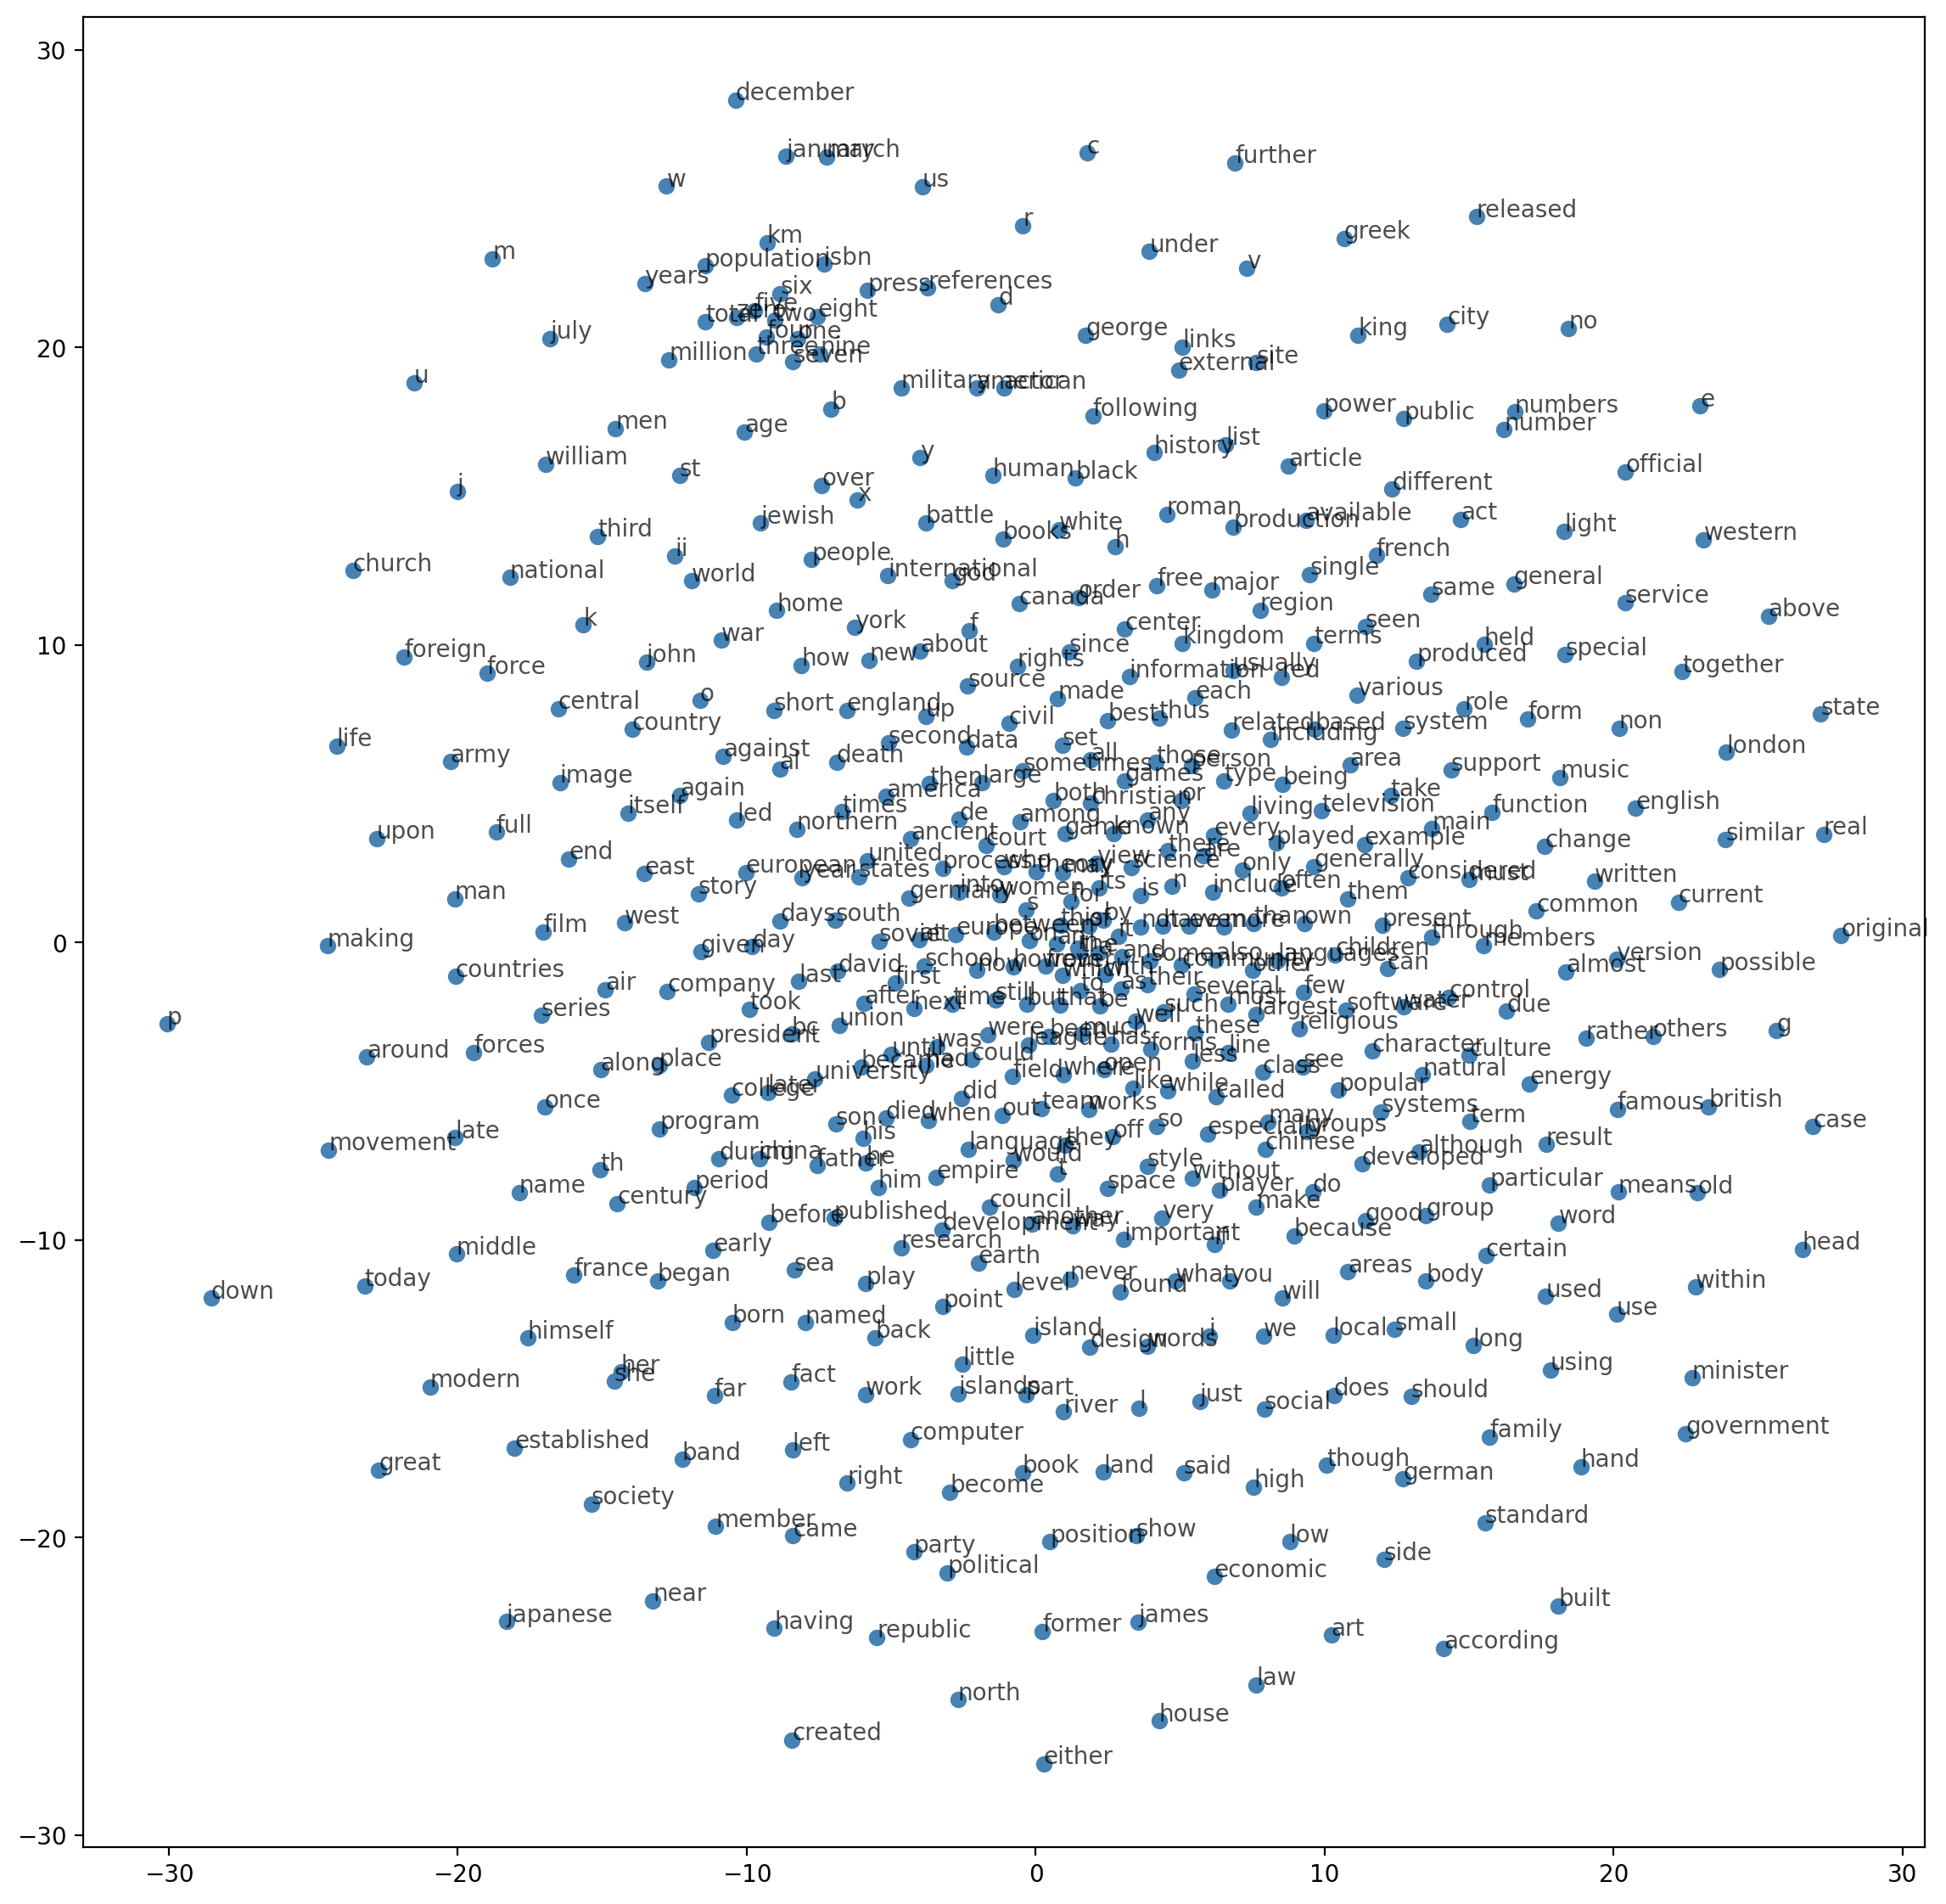

In [30]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)